In [1]:
#!/usr/bin/python
# -*- coding: GBK -*-
%matplotlib inline
from lxml import etree
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain

In [2]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in range(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

In [3]:
tree = etree.parse("whc-en.xml")
root = tree.getroot()

In [4]:
output = dict()
output['raw'] = []
output['crs'] = []
output['lon'] = []
output['lat'] = []

for each in root.xpath('row'):
    each_lat = each.xpath('latitude')
    output['lat'].append(each_lat[0].text)
    each_lon = each.xpath('longitude')
    output['lon'].append(each_lon[0].text)
    each_crs = each.xpath('id_number')
    output['crs'].append(each_crs[0].text)
    each_raw = each.xpath('short_description')
    output['raw'].append(each_raw[0].text)

In [5]:
df = pd.DataFrame(output)
df = df.replace({'raw': 0}, None)
df = df.dropna()
df[['lon', 'lat']] = df[['lon', 'lat']].astype(float)

In [6]:
shp = fiona.open('CHN_adm_shp/CHN_adm3.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1]) # lower-left
ur = (bds[2], bds[3]) # upper-right
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]
print(coords)
print('w = {}, h = {}'.format(w, h))

[73.55770111083996, 18.159305572509766, 134.77392578125, 53.5608596801759]
w = 61.21622467041004, h = 35.401554107666136


In [7]:
m = Basemap(
    projection='tmerc',
    lon_0 = (coords[0] + coords[2])/2,
    lat_0 = (coords[1] + coords[3])/2,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra + 0.05 * w,
    llcrnrlat=coords[1] - extra - 0.1 * h,
    urcrnrlon=coords[2] + extra + 0.05 * w,
    urcrnrlat=coords[3] + extra - 0.1 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

(2408,
 5,
 [73.55770111083996, 18.159305572509766, 0.0, 0.0],
 [134.77392578125, 53.5608596801759, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x128a3e5f8>)

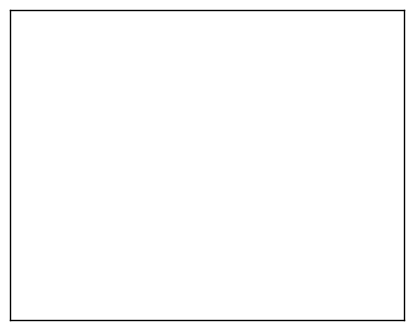

In [8]:
m.readshapefile(
    'CHN_adm_shp/CHN_adm3',
    name='china',
    color='none',
    zorder=2)

In [9]:
n = Basemap(
    projection='tmerc',
    lon_0 = (coords[0] + coords[2])/2,
    lat_0 = (coords[1] + coords[3])/2,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra + 0.05 * w,
    llcrnrlat=coords[1] - extra - 0.1 * h,
    urcrnrlon=coords[2] + extra + 0.05 * w,
    urcrnrlat=coords[3] + extra - 0.1 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

(22,
 5,
 [116.70999908447266, 20.697500228881836, 0.0, 0.0],
 [122.10847473144545, 26.385419845581104, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x11d1320f0>)

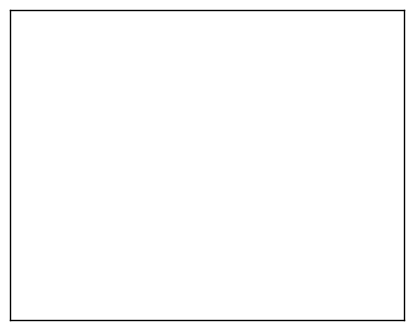

In [10]:
n.readshapefile(
    'TWN_adm_shp/TWN_adm2',
    name='taiwan',
    color='none',
    zorder=2)

In [11]:
# set up a map dataframe for China
df_map_cn = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.china],
    'ward_name': [ward['NAME_3'] for ward in m.china_info]})
df_map_cn['area_m'] = df_map_cn['poly'].map(lambda x: x.area)
df_map_cn['area_km'] = df_map_cn['area_m'] / 100000

In [12]:
# set up a map dataframe for Taiwan
df_map_tw = pd.DataFrame({
    'poly': [Polygon(xy) for xy in n.taiwan],
    'ward_name': [ward['NAME_2'] for ward in n.taiwan_info]})
df_map_tw['area_m'] = df_map_tw['poly'].map(lambda x: x.area)
df_map_tw['area_km'] = df_map_tw['area_m'] / 100000

In [13]:
rows_cn = df_map_cn.poly.count()
rows_tw = df_map_tw.poly.count()
df_map_tw.set_index([list(range(rows_cn+1, rows_cn+rows_tw+1))], inplace=True)

In [14]:
df_map = df_map_cn.append(df_map_tw)

In [15]:
# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df['lon'], df['lat'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, plaque_points)
ldn_points = list(ldn_points)

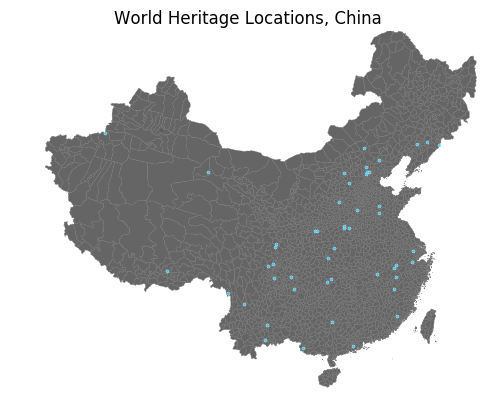

In [16]:
# draw ward patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#555555',
    ec='#787878', lw=.25, alpha=.9,
    zorder=4))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
dev = m.scatter(
    [geom.x for geom in ldn_points],
    [geom.y for geom in ldn_points],
    5, marker='o', lw=.25,
    facecolor='#33ccff', edgecolor='w',
    alpha=0.9, antialiased=True,
    label='World Heritages in China', zorder=3)
# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
# # copyright and source data info
# smallprint = ax.text(
#     1.03, -0.1,
#     'Total heritages: %s \nData from the UN' % len(ldn_points),
#     ha='right', va='bottom',
#     size=5,
#     color='#555555',
#     transform=ax.transAxes)

# # Draw a map scale
# m.drawmapscale(
#     coords[0] + 0.2, coords[1] + 0.02,
#     coords[0], coords[1],
#     1000.,
#     barstyle='fancy', labelstyle='simple',
#     fillcolor1='w', fillcolor2='#555555',
#     fontcolor='#555555',
#     zorder=5)
plt.title("World Heritage Locations, China")
plt.tight_layout()
# this will set the image width to 722px at 100dpi
fig.set_size_inches(5, 5)
plt.savefig('Chinese_heritage.png', dpi=100, alpha=True)
plt.show()

Choropleth map.

In [17]:
df_map['count'] = df_map['poly'].map(lambda x: int(len(list(filter(prep(x).contains, ldn_points)))))
df_map['density_m'] = df_map['count'] / df_map['area_m']
df_map['density_km'] = df_map['count'] / df_map['area_km']
# it's easier to work with NaN values when classifying
df_map.replace(to_replace={'density_m': {0: np.nan}, 'density_km': {0: np.nan}}, inplace=True)

In [18]:
# # Calculate Jenks natural breaks for density
# breaks = nb(
#     df_map[df_map['count'].notnull()]['count'].values,
#     initial=300,
#     k=5)
# # the notnull method lets us match indices when joining
# jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['count'].notnull()].index)
# df_map = df_map.join(jb)
# df_map.jenks_bins.fillna(-1, inplace=True)
# jenks_labels = ["<= %0.1f" % (b) for b in breaks.bins]
# # jenks_labels.insert(0, 'No region (%s regions)' % len(df_map[df_map['density_km'].isnull()]))

In [19]:
# # User-defined jenks bins
# def self_categorize(entry, breaks):
#     for i in range(len(breaks)-1):
#         if entry > breaks[i] and entry <= breaks[i+1]:
#             return i
#     return -1

# breaks = [0.] + [1., 2., 3. ,4. ,] + [1e20]
# df_map['jenks_bins'] = df_map['count'].apply(self_categorize, args=(breaks,))
# jenks_labels = ['No heritage sites']+["= %d heritages sites"%(perc) for perc in breaks[:-1]]

In [20]:
# # User-defined jenks bins
# def self_categorize(entry, breaks):
#     for i in range(len(breaks)-1):
#         if entry >= breaks[i] and entry < breaks[i+1]:
#             return i
#     return 0

# breaks = [0., 1., 2., 3. ,4. ,5.] + [1e20]
# df_map['jenks_bins'] = df_map['count'].apply(self_categorize, args=(breaks,))
# jenks_labels = ["= %d heritages sites"%(perc) for perc in breaks[:-1]]

# print(jenks_labels)

In [21]:
# User-defined jenks bins
def self_categorize(entry, breaks):
    for i in range(len(breaks)-1):
        if entry >= breaks[i] and entry < breaks[i+1]:
            return i
    return 0

breaks = [0., 1., 2., 3. ,4.] + [1e20]
df_map['jenks_bins'] = df_map['count'].apply(self_categorize, args=(breaks,))
jenks_labels = ["= %d heritages sites"%(perc) for perc in breaks[:-1]]

print(jenks_labels)

['= 0 heritages sites', '= 1 heritages sites', '= 2 heritages sites', '= 3 heritages sites', '= 4 heritages sites']


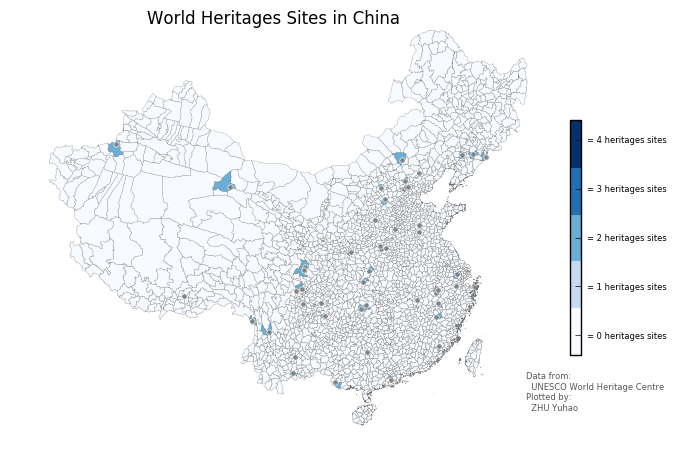

In [22]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')

# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=0.75, zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)

# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=6)

# # Show highest densities, in descending order
# highest = '\n'.join(
#     value[1] for _, value in df_map[(df_map['jenks_bins'] == 4)][:10].sort().iterrows())
# highest = 'Most Dense Region:\n' + highest

# # Subtraction is necessary for precise y coordinate alignment
# details = cb.ax.text(
#     -1., 0 - 0.007,
#     highest,
#     ha='right', va='bottom',
#     size=5,
#     color='#555555')

# Bin method, copyright and source data info
smallprint = ax.text(
    0.98, 0.08,
    'Data from:\n  UNESCO World Heritage Centre\nPlotted by:\n  ZHU Yuhao',
    ha='left', va='bottom',
    size=6,
    color='#555555',
    transform=ax.transAxes)

m.scatter(
    [geom.x for geom in ldn_points],
    [geom.y for geom in ldn_points],
    15, marker='o', lw=.5,
    facecolor='grey', edgecolor='w',
    alpha=0.9, antialiased=True,
    label='World Heritages in China', zorder=3, ax=ax,)

# # Draw a map scale
# m.drawmapscale(coords[0] + 0.08, coords[1] + -0.01,
#     (coords[0] + coords[2])/2, (coords[1] + coords[3])/2, length = 2000.,
#     fontsize=6, barstyle='fancy', labelstyle='simple',
#     fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
#     zorder=0, ax=ax,)

ax.set_title('World Heritages Sites in China')

# this will set the image width to 722px at 100dpi
plt.tight_layout()
fig.set_size_inches(7.22, 5.25)
plt.savefig('world_heritage_china_choropleth.png', dpi=200, alpha=True)
plt.show()